In [1]:
!pip install eli5


In [2]:
import eli5
from IPython.display import display


In [3]:
!pip install scikit-learn


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("telecom_churn_data_200.csv")
df.head()


,customer_id,tenure_months,call_duration_avg,complaints,recharge_freq,churn
0,2001,8,147,1,9,1
1,2002,2,98,6,8,0
2,2003,18,99,1,1,0
3,2004,16,387,6,9,0
4,2005,15,270,6,4,0


In [10]:
X = df[['tenure_months', 'call_duration_avg', 'complaints', 'recharge_freq']]
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[ 6 10]
 [15  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.38      0.32        16
           1       0.47      0.38      0.42        24

    accuracy                           0.38        40
   macro avg       0.38      0.38      0.37        40
weighted avg       0.40      0.38      0.38        40



In [14]:
perm = PermutationImportance(clf, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())


Weight,Feature
-0.0550 ± 0.0663,recharge_freq
-0.0550 ± 0.0663,tenure_months
-0.0550 ± 0.1356,complaints
-0.0750 ± 0.1304,call_duration_avg


In [16]:
def segment_customer(row):
    if row['churn'] == 1:
        return 'At Risk'
    elif row['tenure_months'] > 18 and row['complaints'] == 0:
        return 'Loyal'
    elif row['tenure_months'] < 6 and row['call_duration_avg'] < 100:
        return 'Dormant'
    else:
        return 'Other'

df['segment'] = df.apply(segment_customer, axis=1)
print(df['segment'].value_counts())


segment
At Risk    106
Other       84
Loyal        6
Dormant      4
Name: count, dtype: int64


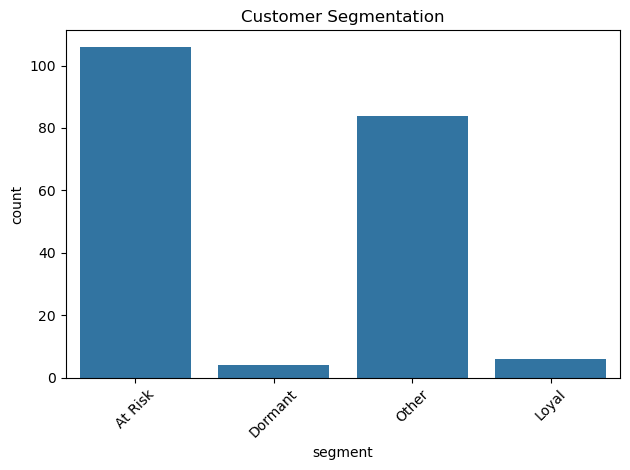

In [18]:
sns.countplot(data=df, x='segment')
plt.title("Customer Segmentation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
import sqlite3
import pandas as pd

df = pd.read_csv('telecom_churn_data_200.csv')

conn = sqlite3.connect('telecom_churn.db')
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS telecom_churn_data (
    customer_id INTEGER,
    tenure_months INTEGER,
    call_duration_avg INTEGER,
    complaints INTEGER,
    recharge_freq INTEGER,
    churn INTEGER
)
''')

df.to_sql('telecom_churn_data', conn, if_exists='replace', index=False)

conn.commit()


In [ ]:
query1 = '''SELECT customer_id, SUM(call_duration_avg) AS total_call_duration, SUM(complaints) AS total_complaints
            FROM telecom_churn_data GROUP BY customer_id;'''

query2 = '''SELECT churn, AVG(recharge_freq) AS avg_recharge_freq
            FROM telecom_churn_data GROUP BY churn;'''

query3 = '''SELECT customer_id, complaints, recharge_freq
            FROM telecom_churn_data
            WHERE complaints > 3 AND recharge_freq < 3;'''

for i, query in enumerate([query1, query2, query3], 1):
    print(f"\nQuery {i} Result:")
    result = pd.read_sql_query(query, conn)
    print(result)

conn.close()
